In [2]:
import pdr
# from method.download_method import download_with_requests
from pathlib import Path
from tqdm import tqdm

PRODUCT_ID = "S_00563101"

url_prefix = "https://pds-geosciences.wustl.edu/mro/mro-m-sharad-5-radargram-v2/mrosh_2101/"
# geom_lbl_url = url_prefix + "DATA/GEOM/S_0201XX/S_02014501_GEOM.LBL"
# geom_table_url = url_prefix + "DATA/GEOM/S_0201XX/S_02014501_GEOM.TAB"
# rdr_lbl_url = url_prefix + "DATA/RGRAM/S_0201XX/S_02014501_RGRAM.LBL"
# rdr_img_url = url_prefix + "DATA/RGRAM/S_0201XX/S_02014501_RGRAM.IMG"
geom_lbl_url = url_prefix + "DATA/GEOM/S_0056XX/S_00563101_GEOM.LBL"
geom_table_url = url_prefix + "DATA/GEOM/S_0056XX/S_00563101_GEOM.TAB"
rdr_lbl_url = url_prefix + "DATA/RGRAM/S_0056XX/S_00563101_RGRAM.LBL"
rdr_img_url = url_prefix + "DATA/RGRAM/S_0056XX/S_00563101_RGRAM.IMG"
save_path = "data/RDR/rdr_data"
urls = [geom_lbl_url, geom_table_url, rdr_lbl_url, rdr_img_url]
filenames = [Path(url).name for url in urls]
# download_with_requests(urls, filenames, save_path, overwrite=False)

In [3]:
geom = pdr.read(save_path + '/' + filenames[0])
geom

pdr.Data(e:\PycharmProjects\mars_sim_web\method\sharad_sim\data\RDR\rdr_data\S_00563101_GEOM.LBL)
keys=['LABEL', 'TABLE']
not yet loaded: ('LABEL', 'TABLE')

In [4]:
geom = geom['TABLE']
# 调整LONGITUDE的值，使其从0-360变为-180到180之间
geom.loc[geom['LONGITUDE'] > 180, 'LONGITUDE'] -= 360
geom

,RADARGRAM COLUMN,TIME,LATITUDE,LONGITUDE,MARS RADIUS,SPACECRAFT RADIUS,RADIAL VELOCITY,TANGENTIAL VELOCITY,SZA,PHASE/1.0E16
0,1,2007-10-09T04:46:06.898,-59.6699,-100.6883,3382.707,3634.001,18.6361,3456.0078,103.48,0.062
1,2,2007-10-09T04:46:07.035,-59.6776,-100.6903,3382.705,3633.998,18.6319,3456.0083,103.48,0.062
2,3,2007-10-09T04:46:07.183,-59.6854,-100.6924,3382.703,3633.996,18.6273,3456.0085,103.47,0.062
3,4,2007-10-09T04:46:07.321,-59.6931,-100.6944,3382.701,3633.993,18.6231,3456.0088,103.46,0.062
4,5,2007-10-09T04:46:07.469,-59.7009,-100.6965,3382.699,3633.990,18.6185,3456.0090,103.46,0.062
...,...,...,...,...,...,...,...,...,...,...
7425,7426,2007-10-09T05:03:50.781,-62.2462,84.9323,3382.338,3632.004,-15.2149,3457.6067,56.23,1.850
7426,7427,2007-10-09T05:03:50.918,-62.2384,84.9299,3382.340,3632.006,-15.2194,3457.6067,56.22,1.850
7427,7428,2007-10-09T05:03:51.066,-62.2306,84.9276,3382.342,3632.008,-15.2243,3457.6067,56.22,1.850
7428,7429,2007-10-09T05:03:51.204,-62.2229,84.9253,3382.344,3632.010,-15.2288,3457.6069,56.21,1.850


In [12]:
RGRAM = pdr.read(save_path + '/' + filenames[2])
RGRAM = RGRAM['IMAGE']
RGRAM

c:\ProgramData\Anaconda3\envs\py_3_9_10\lib\site-packages\pdr\pdr.py:405: UserWarning: Unable to load IMAGE: cannot reshape array of size 25178112 into shape (3600,7430)
  warnings.warn(f"Unable to load {name}: {ex}")


<MultiDict('LINES': 3600, 'LINE_SAMPLES': 7430, 'SAMPLE_TYPE': 'PC_REAL', 'SAMPLE_BITS': 32, 'DESCRIPTION': 'Radar backscatter power.')>

In [17]:
import numpy as np
from matplotlib import pyplot as plt


def process_img_for_plot(img):
    # log处理
    imgScale = np.log10(img + 1e-30)
    # 获取实际的值
    imgValid = imgScale[img != 0]
    # 使图像分布在0-255
    p10 = np.percentile(imgValid, 10)
    m = 255 / (imgValid.max() - p10)
    b = -p10 * m
    # 去除最小值
    img = imgScale * m + b
    img[img < 0] = 0
    return img

(-0.5, 2735.5, 3599.5, -0.5)

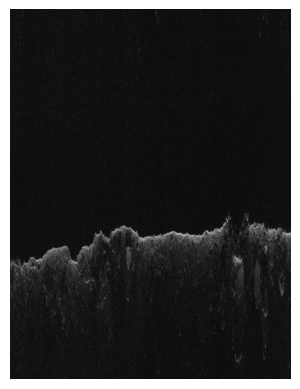

In [6]:
RGRAM = process_img_for_plot(RGRAM)
plt.imshow(RGRAM, cmap='gray')
plt.axis('off')

In [7]:
point_count = geom.shape[0]
point_count

2736

In [8]:
mars_radius = 3396190


# 经纬度转笛卡尔坐标,输入一个dt_lonlat类型的数组，输出一个dt_cartesian类型的数组
def lonlat_to_cartesian(lon_lat):
    lon = lon_lat[0]
    lat = lon_lat[1]
    lon = np.radians(lon)
    lat = np.radians(lat)
    x = mars_radius * np.cos(lat) * np.cos(lon)
    y = mars_radius * np.cos(lat) * np.sin(lon)
    z = mars_radius * np.sin(lat)
    return np.array([x, y, z])


# 笛卡尔坐标转经纬度,输入一个dt_cartesian类型的数组，输出一个dt_lonlat类型的数组
def cartesian_to_lonlat(cartesian):
    x = cartesian[0]
    y = cartesian[1]
    z = cartesian[2]
    lon = np.arctan2(y, x)
    lat = np.arcsin(z / np.linalg.norm(cartesian, axis=0))
    # 转换为角度
    lon = np.degrees(lon)
    lat = np.degrees(lat)
    return np.array([lon, lat])

In [9]:
# test,输入[sqrt(2),sqrt(2),2],查看输出
test = np.array([np.sqrt(2), np.sqrt(2), 2])
test = cartesian_to_lonlat(test)
test

array([45., 45.])

In [10]:
# test,输入(45,45),查看输出
test = np.array([45, 45])
test = lonlat_to_cartesian(test)
test

array([1698095.        , 1698095.        , 2401468.97919794])

In [11]:
def get_sim_area_lonlat(geom):
    # 初始化笛卡尔和经纬度坐标存储数组
    sim_area_cartesian = np.zeros((point_count, 3001, 3, 3))
    sim_area_lonlat = np.zeros((point_count, 3001, 3, 2))
    # 提取所有星下点经纬度，转化为笛卡尔坐标
    sat_lon_lat = geom[['LONGITUDE', 'LATITUDE']].values.T
    # 转换为dt_cartesian类型
    sat_cartesian = lonlat_to_cartesian(sat_lon_lat)
    # 计算速度向量，最后一个点的速度向量近似为倒数第二个点的速度向量,如何定义两个dt_cartesian类型的数组相减？
    sat_v_vec = sat_cartesian[:, 1:] - sat_cartesian[:, :-1]
    # 将sat_v_vec的最后一个值加在sat_v_vec末尾
    sat_v_vec = np.hstack((sat_v_vec, sat_v_vec[:, -1].reshape(3, 1)))
    # 计算crosstrack速度向量的单位向量
    sat_v_crosstrack_vec = np.cross(sat_cartesian, sat_v_vec, axis=0)
    sat_v_crosstrack_vec = sat_v_crosstrack_vec / np.linalg.norm(sat_v_crosstrack_vec, axis=0)
    # 计算alongtrack速度向量的单位向量
    sat_v_alongtrack_vec = np.cross(sat_v_crosstrack_vec, sat_cartesian, axis=0)
    sat_v_alongtrack_vec = sat_v_alongtrack_vec / np.linalg.norm(sat_v_alongtrack_vec, axis=0)
    # 设置步长
    step_crosstrack = 30
    step_alongtrack = 200
    # 以sat_cartesian为中心，向两侧扩展
    sim_area_cartesian[:, 1500, 1, :] = sat_cartesian.T
    sim_area_lonlat[:, 1500, 1, :] = sat_lon_lat.T
    for i in range(1, 1501):
        sim_area_cartesian[:, 1500 - i, 1, :] = sat_cartesian.T - sat_v_crosstrack_vec.T * step_crosstrack * i
        sim_area_cartesian[:, 1500 + i, 1, :] = sat_cartesian.T + sat_v_crosstrack_vec.T * step_crosstrack * i
    # 初始化alongtrack方向的向量
    sat_v_alongtrack_vec_list = np.zeros((point_count, 3001, 3))
    # 每一个point_count，sat_v_alongtrack_vec_list都是一样的等于对应的sat_v_alongtrack_vec * step_alongtrack
    for i in range(point_count):
        sat_v_alongtrack_vec_list[i, :, :] = sat_v_alongtrack_vec.T[i] * step_alongtrack
    # alongtrack方向的向量+和-，分别对应sim_area_cartesian的第一列和第三列
    sim_area_cartesian[:, :, 0, :] = sim_area_cartesian[:, :, 1, :] + sat_v_alongtrack_vec_list
    sim_area_cartesian[:, :, 2, :] = sim_area_cartesian[:, :, 1, :] - sat_v_alongtrack_vec_list
    sim_area_lonlat = cartesian_to_lonlat(sim_area_cartesian.reshape(point_count * 3001 * 3, 3).T).T
    sim_area_lonlat = sim_area_lonlat.reshape(point_count, 3001, 3, 2)
    return sim_area_lonlat

In [12]:
sim_area_lonlat = get_sim_area_lonlat(geom)
sim_area_lonlat

array([[[[-19.05368313,  30.73581542],
         [-19.05323473,  30.73916715],
         [-19.0527863 ,  30.74251889]],

        [[-19.05309826,  30.73575761],
         [-19.05264984,  30.73910935],
         [-19.05220138,  30.74246108]],

        [[-19.05251338,  30.7356998 ],
         [-19.05206494,  30.73905153],
         [-19.05161647,  30.74240327]],

        ...,

        [[-17.30331615,  30.5507476 ],
         [-17.30280805,  30.55409293],
         [-17.30229992,  30.55743826]],

        [[-17.30273351,  30.55068197],
         [-17.30222539,  30.5540273 ],
         [-17.30171724,  30.55737262]],

        [[-17.30215088,  30.55061634],
         [-17.30164274,  30.55396167],
         [-17.30113456,  30.55730699]]],


       [[[-19.05486165,  30.726952  ],
         [-19.0544193 ,  30.73030433],
         [-19.05397693,  30.73365666]],

        [[-19.05427673,  30.72689497],
         [-19.05383436,  30.7302473 ],
         [-19.05339197,  30.73359963]],

        [[-19.05369181,  30.7268

In [13]:
from method.mola.mola import get_mola
from scipy.interpolate import griddata
from pyresample import geometry, kd_tree
from scipy.interpolate import RegularGridInterpolator


def get_sim_area_cartesian(sim_area_lonlat):
    sim_area_cartesian = np.zeros((point_count, 3001, 3, 3))
    pbar = tqdm(total=sim_area_lonlat.shape[0], desc="插值仿真区域的DEM")
    for i in range(sim_area_lonlat.shape[0]):
        max_lon = sim_area_lonlat[i, :, :, 0].max()
        min_lon = sim_area_lonlat[i, :, :, 0].min()
        max_lat = sim_area_lonlat[i, :, :, 1].max()
        min_lat = sim_area_lonlat[i, :, :, 1].min()
        # 生成经纬度范围
        lon_range = [min_lon, max_lon]
        lat_range = [min_lat, max_lat]
        # 获取mola数据
        mola_data, lon_index, lat_index, _, _, _ = get_mola(lon_range, lat_range)
        # 如果mola_data中有nan，输出lon_range，lat_range
        if np.isnan(mola_data).any():
            print(lon_range, lat_range)
            pbar.update(1)
            continue
        lon_grid, lat_grid = np.meshgrid(lon_index, lat_index)
        # 获取mola数据的经纬度
        mola_data = mola_data.flatten()
        lon_grid = lon_grid.flatten()
        lat_grid = lat_grid.flatten()
        swath_def = geometry.SwathDefinition(lons=lon_grid, lats=lat_grid)

        # 定义目标区域的空间信息
        lons_target, lats_target = sim_area_lonlat[i, :, :, 0].flatten(), sim_area_lonlat[i, :, :, 1].flatten()
        target_def = geometry.SwathDefinition(lons=lons_target, lats=lats_target)

        # 重采样
        dem_inter = kd_tree.resample_gauss(swath_def, mola_data, target_def, radius_of_influence=300, sigmas=200,
                                           fill_value=None)
        # 获得半径
        radius = dem_inter + mars_radius
        # 将radius，lat_inter，lon_inter转换为3001*3的数组
        radius = radius.reshape(3001, 3)
        lats_target = lats_target.reshape(3001, 3)
        lons_target = lons_target.reshape(3001, 3)
        # 获得笛卡尔坐标
        # 将经纬度转换为笛卡尔坐标
        sim_area_cartesian[i, :, :, 0] = radius * np.cos(lats_target * np.pi / 180) * np.cos(lons_target * np.pi / 180)
        sim_area_cartesian[i, :, :, 1] = radius * np.cos(lats_target * np.pi / 180) * np.sin(lons_target * np.pi / 180)
        sim_area_cartesian[i, :, :, 2] = radius * np.sin(lats_target * np.pi / 180)
        pbar.update(1)
    pbar.close()
    return sim_area_cartesian

In [14]:
sim_area_cartesian = get_sim_area_cartesian(sim_area_lonlat)

插值仿真区域的DEM: 100%|██████████| 2736/2736 [00:37<00:00, 73.87it/s]


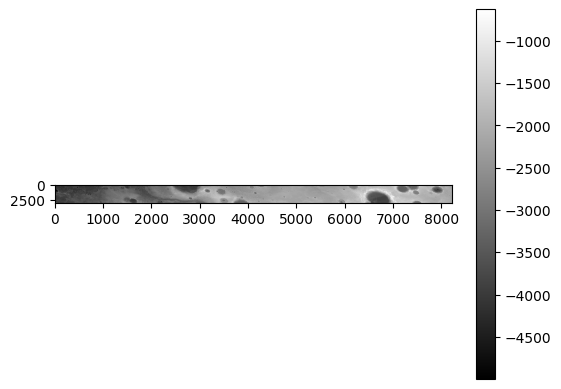

In [15]:
radius = sim_area_cartesian.reshape(point_count * 3001 * 3, 3)
radius = np.linalg.norm(radius, axis=1) - 3396190
radius = radius.reshape(point_count, 3001, 3)
# 使用transpose将3001和3的维度交换位置
transposed_radius = radius.transpose(0, 2, 1)

# 使用reshape变为(point_count * 3) x 3001的形状
reshaped_radius = transposed_radius.reshape(point_count * 3, 3001)
plt.imshow(reshaped_radius.T, cmap='gray')
plt.colorbar()
# 横轴和纵轴的ax长度比值为3001：point_count * 20
plt.gca().set_aspect(1000 / (point_count * 3))

In [16]:
# 每一个(3001,3)网格点的nas索引，用来表达3000*4个facet,每一个point_count的剖分都是一样的
facet_index = np.zeros((3000 * 4, 3, 2), dtype=int)
# 例如：第一个三角形的三个点的索引为[[0,0],[0,1]],[1,0]],第二个三角形的三个点的索引为[[0,1],[1,1]],[1,0]]
# 遍历每一个方格
counter = 0
for i in range(3000):
    for j in range(2):
        # 定义四个点
        top_left = [i, j]
        top_right = [i, j + 1]
        bottom_left = [i + 1, j]
        bottom_right = [i + 1, j + 1]

        # 第一个三角形
        facet_index[counter, 0] = top_left
        facet_index[counter, 1] = bottom_left
        facet_index[counter, 2] = top_right
        counter += 1

        # 第二个三角形
        facet_index[counter, 0] = top_right
        facet_index[counter, 1] = bottom_right
        facet_index[counter, 2] = bottom_left
        counter += 1

In [17]:

# 求对应半径
radius = np.linalg.norm(sim_area_cartesian, axis=3)
np.max(radius)

3395562.0

0.746258020401001
0.013002395629882812
0.00800180435180664


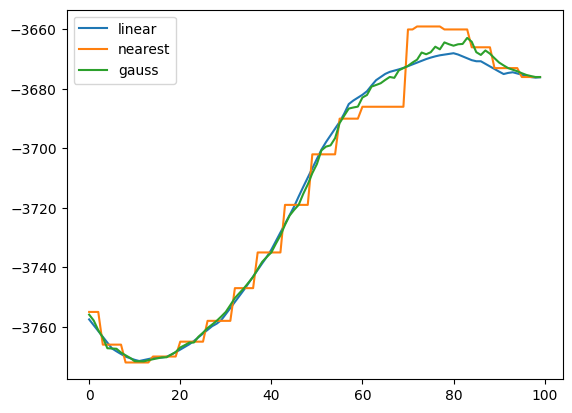

In [18]:
import time

max_lon = sim_area_lonlat[2, :, :, 0].max()
min_lon = sim_area_lonlat[2, :, :, 0].min()
max_lat = sim_area_lonlat[2, :, :, 1].max()
min_lat = sim_area_lonlat[2, :, :, 1].min()
# 生成经纬度范围
lon_range = [min_lon, max_lon]
lat_range = [min_lat, max_lat]
# 获取mola数据
mola_data, lon_index, lat_index, _, _, _ = get_mola(lon_range, lat_range)
# 如果mola_data中有nan，输出lon_range，lat_range
lon_grid, lat_grid = np.meshgrid(lon_index, lat_index)
# 获取mola数据的经纬度
mola_data = mola_data.flatten()
lon_grid = lon_grid.flatten()
lat_grid = lat_grid.flatten()
index_range = [1300, 1400]
start_time = time.time()
# 获取仿真区域的经纬度
dem_inter = griddata((lon_grid, lat_grid), mola_data,
                     (sim_area_lonlat[2, :, :, 0].flatten(), sim_area_lonlat[2, :, :, 1].flatten()), method='linear')
dem_inter = dem_inter.reshape(3001, 3)
from matplotlib import pyplot as plt

plt.plot(dem_inter[index_range[0]:index_range[1], 1])
print(time.time() - start_time)
start_time = time.time()
# 获取仿真区域的经纬度
dem_inter = griddata((lon_grid, lat_grid), mola_data,
                     (sim_area_lonlat[2, :, :, 0].flatten(), sim_area_lonlat[2, :, :, 1].flatten()), method='nearest')
dem_inter = dem_inter.reshape(3001, 3)
from matplotlib import pyplot as plt

plt.plot(dem_inter[index_range[0]:index_range[1], 1])
print(time.time() - start_time)
start_time = time.time()
from pyresample import geometry, kd_tree

# 定义原始数据的空间信息
lons, lats = lon_grid, lat_grid  # 这是你展平后的数据
data = mola_data
swath_def = geometry.SwathDefinition(lons=lons, lats=lats)

# 定义目标区域的空间信息
lons_target, lats_target = sim_area_lonlat[2, :, :, 0].flatten(), sim_area_lonlat[2, :, :, 1].flatten()
target_def = geometry.SwathDefinition(lons=lons_target, lats=lats_target)

# 重采样
result = kd_tree.resample_gauss(swath_def, data, target_def, radius_of_influence=300, sigmas=200, fill_value=None)

# 如果需要，可以对结果进行reshape
dem_inter = result.reshape(3001, 3)

plt.plot(dem_inter[index_range[0]:index_range[1], 1])
print(time.time() - start_time)
plt.legend(['linear', 'nearest', 'gauss'])

In [15]:
lon_lat = sim_area_lonlat.reshape(point_count * 3001 * 3, 2)

In [16]:
from method.geological_units.get_geological_units import get_units
from method.attributes_database.hirise_to_db import get_corL_rmsH
from method.attributes_database.perimittivity_to_db import get_permittivity

unit = get_units(lon_lat[:, 0], lon_lat[:, 1])
corL,rmsH = get_corL_rmsH(unit)

In [19]:
permittivity = get_permittivity(unit)

array(['HNt', 'HNt', 'HNt', ..., 'mNh', 'mNh', 'mNh'], dtype=object)

In [222]:
import numpy as np
from matplotlib import pyplot as plt


def process_img_for_plot(img):
    # log处理
    imgScale = np.log10(img + 1e-30)
    # 获取实际的值
    imgValid = imgScale[img != 0]
    # 使图像分布在0-255
    p10 = np.percentile(imgValid, 10)
    m = 255 / (imgValid.max() - p10)
    b = -p10 * m
    # 去除最小值
    img = imgScale * m + b
    img[img < 0] = 0
    return img
# S_01224201    S_00170101  S_03280801  S_03289201
PRODUCT_ID = "S_03289201"
data_dict = np.load('data/result/'+PRODUCT_ID+'.npy',allow_pickle=True).item()

In [223]:
sim_area_cartesian = data_dict['sim_area_cartesian']
point_count = data_dict['point_count']
rgram = data_dict['rgram_data']
rgram_vv = data_dict['rgram_vv']

In [224]:
radius = sim_area_cartesian.reshape(point_count * 3001 * 3, 3)
radius = np.linalg.norm(radius, axis=1) - 3396190
radius = radius.reshape(point_count, 3001, 3)
# 使用transpose将3001和3的维度交换位置
transposed_radius = radius.transpose(0, 2, 1)

# 使用reshape变为(point_count * 3) x 3001的形状
reshaped_radius = transposed_radius.reshape(point_count * 3, 3001)

In [225]:
# from matplotlib.gridspec import GridSpec
# # 竖着的3幅图
# fig, ax = plt.subplots(3, 1)
# # 图的figsize
# fig.set_size_inches(point_count/350, 30)
# #第一幅图
# ax[0].imshow(process_img_for_plot(rgram), cmap='gray')
# ax[1].imshow(process_img_for_plot(rgram_vv), cmap='gray')
# ax[2].imshow(reshaped_radius.T[:,::3], cmap='gray')
# # 三幅图都不显示坐标轴
# for i in range(3):
#     ax[i].axis('off')
# # 三幅图的横轴尺寸相同
# ax[0].set_aspect(1800 / point_count)
# ax[1].set_aspect(1800 / point_count)
# # 设置新的高度
# ax[0].set_ylim([3600, 0])
# ax[1].set_ylim([3600, 0])
# ax[2].set_ylim([3001,0])
# ax[2].set_aspect(0.1)
# # 调整子图之间的垂直间距
# plt.subplots_adjust(hspace=0.01) 
# plt.tight_layout()

In [226]:
reshaped_radius.shape

(23091, 3001)

In [227]:
rgram.shape

(3600, 7697)

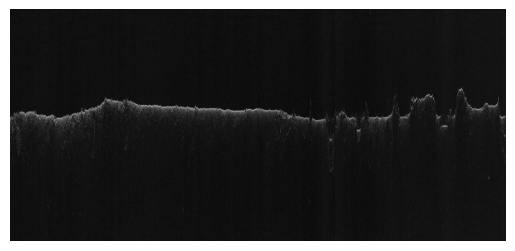

In [228]:
plt.imshow(process_img_for_plot(rgram), cmap='gray')
plt.axis('off')
plt.savefig('data/img/'+PRODUCT_ID+'_1.png',dpi=300,bbox_inches='tight')

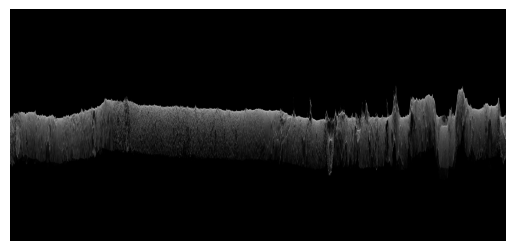

In [229]:
plt.imshow(process_img_for_plot(rgram_vv), cmap='gray')
plt.axis('off')
plt.savefig('data/img/'+PRODUCT_ID+'_2.png',dpi=300,bbox_inches='tight')

In [230]:
delay = data_dict['delay']

In [231]:
temp = delay.reshape(point_count,3000,4)
# 找到每个delay[i,:,:]中最小值的索引
# 在3000的方向上找到最小值的索引
min_indices = np.argmin(temp.reshape(point_count, -1), axis=1)

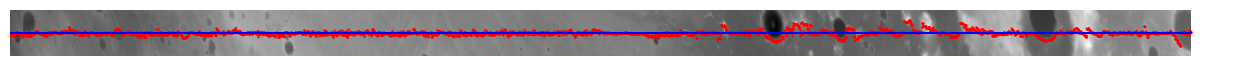

In [232]:
plt.figure(figsize=(16,9))
plt.imshow(reshaped_radius.T, cmap='gray')
x = np.linspace(0, reshaped_radius.shape[0],point_count)
y = np.round(min_indices/4)
plt.scatter(x,y,marker='.',s=1,c='r')
# 画一条中线
plt.plot([0,reshaped_radius.shape[0]],[reshaped_radius.shape[1]/2,reshaped_radius.shape[1]/2],c='b')
# 调整y轴缩放
plt.gca().set_aspect(0.3)
plt.axis('off')
plt.savefig('data/img/'+PRODUCT_ID+'_3.png',dpi=300,bbox_inches='tight')